In [1]:
import random
import datetime
import pandas as pd
import numpy as np
from haversine import haversine
import folium
from datetime import datetime
import time
from tqdm import tqdm
import gc
import geopy.distance
import seaborn as sns
import shap
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,mean_absolute_error, r2_score
import pickle
from tqdm import tqdm

# Load Data

In [2]:
df1 = pd.read_csv("./data/gps_fulldata_20220512_20220819.csv", encoding='shift_jis', usecols=[0,1,2,4,6])
df2 = pd.read_csv("./data/gps_20220820_20221107.csv", encoding='shift_jis', usecols=[1,2,3,5,7])

In [3]:
df = pd.concat([df1, df2],axis=0)
df.sort_values(by=['vehicleCode', 'timestamp'], axis=0, inplace=True)
df.reset_index(drop=True, inplace=True)
df

,vehicleCode,lat,lng,timestamp,distance
0,W1,35.081511,136.931423,2022-05-12T06:41:13+09:00,0.000000
1,W1,35.081820,136.931295,2022-05-12T06:49:47+09:00,36.214071
2,W1,35.081825,136.931280,2022-05-12T06:50:34+09:00,1.476148
3,W1,35.081957,136.931339,2022-05-12T06:50:39+09:00,15.601548
4,W1,35.082085,136.931459,2022-05-12T06:50:44+09:00,17.928186
...,...,...,...,...,...
33839770,座間エンジン（3時区）-2,35.501584,139.439746,2022-11-04T16:55:42+09:00,4.121708
33839771,座間エンジン（3時区）-2,35.501576,139.439728,2022-11-04T16:55:48+09:00,1.858719
33839772,座間エンジン（3時区）-2,35.501510,139.439645,2022-11-04T16:55:53+09:00,10.503742
33839773,座間エンジン（3時区）-2,35.501472,139.439588,2022-11-04T16:55:58+09:00,6.672303


In [4]:
del [[df1, df2]]
gc.collect()
df1 = pd.DataFrame()
df2 = pd.DataFrame()

In [5]:
target_df = df.copy()

# Data preprocessing

In [6]:
target_df['coord'] = target_df[['lat','lng']].apply(lambda x :tuple(x.values), axis=1)

## Define location of each timestamp
- Returns the index of the factory(1,2,3,4) if the location is in the scope of the factory
- Else returns 0

In [7]:
target_place = {}
target_place[1] = (35.50116466410529, 139.7705922117356) # "Higashi-Ogishima"
target_place[2] = (35.55769134902504, 139.66477025889324) # "K1"
target_place[3] = (35.47115639628905, 139.36695126985464) # "Atsugi"
target_place[4] = (35.520388068094086, 139.3521451687072) # "Nakatsu"

def get_gps_location(location, radi):
    for i in target_place.keys():
        if(haversine(location, target_place[i]) < radi):
            return i
    return 0

radi = 0.3 # 300m
target_df['location'] = target_df['coord'].apply(lambda x : get_gps_location(x, radi))
target_df.head()

,vehicleCode,lat,lng,timestamp,distance,coord,location
0,W1,35.081511,136.931423,2022-05-12T06:41:13+09:00,0.000000,"(35.081511, 136.931423)",0
1,W1,35.081820,136.931295,2022-05-12T06:49:47+09:00,36.214071,"(35.08182, 136.931295)",0
2,W1,35.081825,136.931280,2022-05-12T06:50:34+09:00,1.476148,"(35.081825, 136.93128)",0
3,W1,35.081957,136.931339,2022-05-12T06:50:39+09:00,15.601548,"(35.081957, 136.931339)",0
4,W1,35.082085,136.931459,2022-05-12T06:50:44+09:00,17.928186,"(35.082085, 136.931459)",0


In [8]:
# Select vehicleCode that only passes 4 factories

target_pass_result= list(target_df[target_df['location']!=0]['vehicleCode'].unique())
print(target_pass_result)

['W102', 'W103', 'W104', 'W105', 'W106', 'W108', 'W109', 'W110', 'W111', 'W112', 'W113', 'W114', 'W115', 'W117', 'W118', 'W119', 'W120-1', 'W120-2', 'W40-1', 'W40-2', 'W41-1', 'W41-2', 'W42-1', 'W42-2', 'W44-1', 'W44-2', 'W44-スポット', 'W45-1', 'W45-2', 'W46', 'W46-スポット', 'W47-1', 'W47-2', 'W47-3', 'W52', 'W53', 'W54', 'W70', 'W72', 'W73', 'W74', 'W75', 'W76', 'W77', 'W78', 'W79', 'W80', 'W82-2', 'W84', 'W87-1', 'W87-2', 'W88', 'W90', 'W91', 'W92-1', 'W93-1', 'W93-2', 'W94', 'W95-1', 'W95-2', 'W97-1', 'W97-2', 'W98-1', 'W98-2', '座間エンジン（1・2・4時区）-1', '座間エンジン（1・2・4時区）-2', '座間エンジン（3時区）-1', '座間エンジン（3時区）-2']


In [9]:
target_df= target_df[target_df['vehicleCode'].isin(target_pass_result)]
target_df.reset_index(drop=True, inplace=True)
target_df

,vehicleCode,lat,lng,timestamp,distance,coord,location
0,W102,35.534938,139.651564,2022-05-12T03:49:19+09:00,40.923383,"(35.534938, 139.651564)",0
1,W102,35.534921,139.651580,2022-05-12T03:49:20+09:00,2.379729,"(35.534921, 139.65158)",0
2,W102,35.534921,139.651580,2022-05-12T03:49:24+09:00,0.000000,"(35.534921, 139.65158)",0
3,W102,35.534921,139.651580,2022-05-12T03:49:29+09:00,0.000000,"(35.534921, 139.65158)",0
4,W102,35.534976,139.651498,2022-05-12T03:49:31+09:00,9.619799,"(35.534976, 139.651498)",0
...,...,...,...,...,...,...,...
26727857,座間エンジン（3時区）-2,35.501584,139.439746,2022-11-04T16:55:42+09:00,4.121708,"(35.501584, 139.439746)",0
26727858,座間エンジン（3時区）-2,35.501576,139.439728,2022-11-04T16:55:48+09:00,1.858719,"(35.501576, 139.439728)",0
26727859,座間エンジン（3時区）-2,35.501510,139.439645,2022-11-04T16:55:53+09:00,10.503742,"(35.50151, 139.439645)",0
26727860,座間エンジン（3時区）-2,35.501472,139.439588,2022-11-04T16:55:58+09:00,6.672303,"(35.501472, 139.439588)",0


## Remove outlier

In [10]:
lng_margin = [130.8754025956282,143.49215552451497]
lat_margin = [31.939262095093653,39.08345291592023]

def check_outlier(value):
    lat, lng = value
    if ((lng<lng_margin[0]) | (lng>lng_margin[1])|(lat<lat_margin[0]) | (lat>lat_margin[1])):
        return 1
    else :
        return 0

target_df['is_outlier'] = target_df['coord'].apply(lambda x : check_outlier(x))
target_df.drop(target_df[target_df['is_outlier']==1].index, inplace = True)
# target_df.drop(columns=['coord','is_outlier'],axis=1,inplace=True)

target_df.head()

,vehicleCode,lat,lng,timestamp,distance,coord,location,is_outlier
0,W102,35.534938,139.651564,2022-05-12T03:49:19+09:00,40.923383,"(35.534938, 139.651564)",0,0
1,W102,35.534921,139.651580,2022-05-12T03:49:20+09:00,2.379729,"(35.534921, 139.65158)",0,0
2,W102,35.534921,139.651580,2022-05-12T03:49:24+09:00,0.000000,"(35.534921, 139.65158)",0,0
3,W102,35.534921,139.651580,2022-05-12T03:49:29+09:00,0.000000,"(35.534921, 139.65158)",0,0
4,W102,35.534976,139.651498,2022-05-12T03:49:31+09:00,9.619799,"(35.534976, 139.651498)",0,0


In [11]:
target_df.reset_index(inplace=True, drop=True)
target_df

,vehicleCode,lat,lng,timestamp,distance,coord,location,is_outlier
0,W102,35.534938,139.651564,2022-05-12T03:49:19+09:00,40.923383,"(35.534938, 139.651564)",0,0
1,W102,35.534921,139.651580,2022-05-12T03:49:20+09:00,2.379729,"(35.534921, 139.65158)",0,0
2,W102,35.534921,139.651580,2022-05-12T03:49:24+09:00,0.000000,"(35.534921, 139.65158)",0,0
3,W102,35.534921,139.651580,2022-05-12T03:49:29+09:00,0.000000,"(35.534921, 139.65158)",0,0
4,W102,35.534976,139.651498,2022-05-12T03:49:31+09:00,9.619799,"(35.534976, 139.651498)",0,0
...,...,...,...,...,...,...,...,...
26723650,座間エンジン（3時区）-2,35.501584,139.439746,2022-11-04T16:55:42+09:00,4.121708,"(35.501584, 139.439746)",0,0
26723651,座間エンジン（3時区）-2,35.501576,139.439728,2022-11-04T16:55:48+09:00,1.858719,"(35.501576, 139.439728)",0,0
26723652,座間エンジン（3時区）-2,35.501510,139.439645,2022-11-04T16:55:53+09:00,10.503742,"(35.50151, 139.439645)",0,0
26723653,座間エンジン（3時区）-2,35.501472,139.439588,2022-11-04T16:55:58+09:00,6.672303,"(35.501472, 139.439588)",0,0


## Convert data type

In [12]:
import datetime
target_df['timestamp']=target_df['timestamp'].apply(lambda x: datetime.datetime.strptime(x[:-6], '%Y-%m-%dt%H:%M:%S'))

In [ ]:
# Calculate time difference between every timestamp

serials = target_df['vehicleCode'].unique()
for serial in serials:
    target_df.loc[target_df.vehicleCode==serial, 'del_time'] = \
    np.append(0, (target_df.loc[target_df.vehicleCode==serial, 'timestamp'][1:].reset_index(drop=True)-target_df.loc[target_df.vehicleCode==serial, 'timestamp'][:-1].reset_index(drop=True)).apply(lambda x: x.seconds).values)

## Split trips

In [13]:
# If the time between each timestamp is more than 7 hours, 
# we assumed that the truck arrived to its destination and starts the new trip

vehicleCodes=target_df['vehicleCode'].unique()
idx = list(target_df[target_df['del_time']>7*60*60].index)

for i in vehicleCodes:
    idx.append(target_df[target_df['vehicleCode']==i].index[0])
    
idx = sorted(list(set(idx)))

target_df.loc[0, 'interval7'] = 0
target_df.loc[idx, 'interval7'] = np.arange(1, len(idx)+1)
target_df['interval7'].fillna(method='ffill', inplace=True)

## Trip information
- Trip information such as velocity, distance, time from the past data will be meaningful to predict the arrival time
- Based on the `weekday` and `velocity` of each timestamp, we extracted some descriptive statistics as below
    1. **velocity information (mean, standard deviation) for every five second**
    2. **velocity information (mean, standard deviation) for every weekday**
    3. **trip information (distance, time) for every vehicleCode**
- Files are saved on 'constant' folder

In [16]:
target_df['weekday'] = target_df['timestamp'].dt.weekday
target_df['velocity'] = target_df['distance'] / target_df['del_time']
target_df

,vehicleCode,lat,lng,timestamp,distance,coord,location,is_outlier,del_time,interval7,weekday,velocity
0,W102,35.534938,139.651564,2022-05-12 03:49:19,40.923383,"(35.534938, 139.651564)",0,0,0.0,1.0,3,inf
1,W102,35.534921,139.651580,2022-05-12 03:49:20,2.379729,"(35.534921, 139.65158)",0,0,1.0,1.0,3,2.379729
2,W102,35.534921,139.651580,2022-05-12 03:49:24,0.000000,"(35.534921, 139.65158)",0,0,4.0,1.0,3,0.000000
3,W102,35.534921,139.651580,2022-05-12 03:49:29,0.000000,"(35.534921, 139.65158)",0,0,5.0,1.0,3,0.000000
4,W102,35.534976,139.651498,2022-05-12 03:49:31,9.619799,"(35.534976, 139.651498)",0,0,2.0,1.0,3,4.809900
...,...,...,...,...,...,...,...,...,...,...,...,...
26723650,座間エンジン（3時区）-2,35.501584,139.439746,2022-11-04 16:55:42,4.121708,"(35.501584, 139.439746)",0,0,5.0,6818.0,4,0.824342
26723651,座間エンジン（3時区）-2,35.501576,139.439728,2022-11-04 16:55:48,1.858719,"(35.501576, 139.439728)",0,0,6.0,6818.0,4,0.309787
26723652,座間エンジン（3時区）-2,35.501510,139.439645,2022-11-04 16:55:53,10.503742,"(35.50151, 139.439645)",0,0,5.0,6818.0,4,2.100748
26723653,座間エンジン（3時区）-2,35.501472,139.439588,2022-11-04 16:55:58,6.672303,"(35.501472, 139.439588)",0,0,5.0,6818.0,4,1.334461


In [ ]:
# Round timestamp to five seconds
target_df['five_sec'] = target_df['timestamp'].dt.round('5s').dt.time
target_df['five_sec'] = target_df['five_sec'].apply(lambda x: x.strftime("%H:%M:%S"))
target_df.loc[target_df['velocity'] == np.inf, 'velocity'] = 0

# velocity mean for every five second
a = pd.DataFrame(target_df.groupby('five_sec')['velocity'].mean())
a.rename(columns = {'velocity':'velocity_mean_5sec'},inplace=True)

# velocity standard deviation for every five seccond
b = pd.DataFrame(target_df.groupby('five_sec')['velocity'].std())
b.rename(columns = {'velocity':'velocity_std_5sec'},inplace=True)

# velocity information for every five second
df1 = pd.concat([a,b],axis=1).reset_index()

# velocity mean for every weekday
c = pd.DataFrame(target_df.groupby('weekday')['velocity'].mean())
c.rename(columns = {'velocity':'velocity_mean_weekday'},inplace=True)

# velocity standard deviation for every weekday
d = pd.DataFrame(target_df.groupby('weekday')['velocity'].std())
d.rename(columns = {'velocity':'velocity_std_weekday'},inplace=True)

# velocity information for every weekday
df2 = pd.concat([c,d],axis=1).reset_index()

# mean of total distance for every vehicleCode
e = pd.DataFrame(target_df.groupby(["vehicleCode",'interval7']).distance.sum().reset_index().groupby('vehicleCode').distance.mean())
e.rename(columns = {'distance':'total_distance_mean_vehicle'},inplace=True)

# mean of total trip time for every vehicleCode
f = pd.DataFrame(target_df.groupby(["vehicleCode","interval7"]).del_time.sum().reset_index().groupby('vehicleCode').del_time.mean())
f.rename(columns = {'del_time':'total_time_mean_vehicle'},inplace=True)

# trip information for every vehicleCode
df3 = pd.concat([e,f],axis=1).reset_index()

# Save trip information
df1.to_csv("./constant/constant_velocity_5sec.csv", index=False)
df2.to_csv("./constant/constant_velocity_week.csv", index=False)
df3.to_csv("./constant/constant_total_mean.csv", index=False)

In [17]:
# Add features for each timestamp by merging actual data and trip information

target_df = pd.merge(target_df, df1, on='five_sec', how='left')
target_df = pd.merge(target_df, df2, on='weekday', how='left')
target_df = pd.merge(target_df, df3, on='vehicleCode', how='left')
target_df

,vehicleCode,lat,lng,timestamp,distance,coord,location,is_outlier,del_time,interval7,weekday,velocity,five_sec,velocity_mean_5sec,velocity_std_5sec,velocity_mean_weekday,velocity_std_weekday,total_distance_mean_vehicle,total_time_mean_vehicle
0,W102,35.534938,139.651564,2022-05-12 03:49:19,40.923383,"(35.534938, 139.651564)",0,0,0.0,1.0,3,0.000000,03:49:20,11.706075,8.546284,14.280946,504.669762,113718.354540,86089.450382
1,W102,35.534921,139.651580,2022-05-12 03:49:20,2.379729,"(35.534921, 139.65158)",0,0,1.0,1.0,3,2.379729,03:49:20,11.706075,8.546284,14.280946,504.669762,113718.354540,86089.450382
2,W102,35.534921,139.651580,2022-05-12 03:49:24,0.000000,"(35.534921, 139.65158)",0,0,4.0,1.0,3,0.000000,03:49:25,11.671444,9.312073,14.280946,504.669762,113718.354540,86089.450382
3,W102,35.534921,139.651580,2022-05-12 03:49:29,0.000000,"(35.534921, 139.65158)",0,0,5.0,1.0,3,0.000000,03:49:30,13.289898,44.053619,14.280946,504.669762,113718.354540,86089.450382
4,W102,35.534976,139.651498,2022-05-12 03:49:31,9.619799,"(35.534976, 139.651498)",0,0,2.0,1.0,3,4.809900,03:49:30,13.289898,44.053619,14.280946,504.669762,113718.354540,86089.450382
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26723650,座間エンジン（3時区）-2,35.501584,139.439746,2022-11-04 16:55:42,4.121708,"(35.501584, 139.439746)",0,0,5.0,6818.0,4,0.824342,16:55:40,15.487454,59.592917,12.733705,50.916114,122904.112538,86085.165138
26723651,座間エンジン（3時区）-2,35.501576,139.439728,2022-11-04 16:55:48,1.858719,"(35.501576, 139.439728)",0,0,6.0,6818.0,4,0.309787,16:55:50,18.590636,123.697314,12.733705,50.916114,122904.112538,86085.165138
26723652,座間エンジン（3時区）-2,35.501510,139.439645,2022-11-04 16:55:53,10.503742,"(35.50151, 139.439645)",0,0,5.0,6818.0,4,2.100748,16:55:55,16.172334,48.119371,12.733705,50.916114,122904.112538,86085.165138
26723653,座間エンジン（3時区）-2,35.501472,139.439588,2022-11-04 16:55:58,6.672303,"(35.501472, 139.439588)",0,0,5.0,6818.0,4,1.334461,16:56:00,16.108201,59.934680,12.733705,50.916114,122904.112538,86085.165138


# Training Model

## Split Training data
- To build a model that predicts the arrival time to each factory, we have to split the total data into four parts that pass through the factory

In [14]:
# Based on the trips separated from the above code, select trips that pass through each factory

Higashi_pass= list(target_df[target_df['location']==1]['interval7'].unique())
K1_pass= list(target_df[target_df['location']==2]['interval7'].unique())
Atsugi_pass= list(target_df[target_df['location']==3]['interval7'].unique())
Nakatsu_pass= list(target_df[target_df['location']==4]['interval7'].unique())

# Number of trips per factory 

print("Higashi_count = {}\nK1_count = {}\nAtsugi_count = {}\nNakatsu_count = {}".format(len(Higashi_pass),len(K1_pass),len(Atsugi_pass),len(Nakatsu_pass)))

Higashi_count = 1459
K1_count = 4851
Atsugi_count = 1874
Nakatsu_count = 1612


In [15]:
# Select index for each factory to split the total data

Higashi_data_index = []
K1_data_index = []
Atsugi_data_index = []
Nakatsu_data_index = []

for drive in Higashi_pass:
    temp =target_df[target_df['interval7']==drive]
    start = temp.index[0]
    temp = temp[temp['location']==1]
    if(len(temp)<10):
        continue 
    if(temp.iloc[9].location==1):
        end = temp.iloc[9].name
        Higashi_data_index.extend([x for x in range(start,end)])
        
for drive in K1_pass:
    temp =target_df[target_df['interval7']==drive]
    start = temp.index[0]
    temp = temp[temp['location']==2]
    if(len(temp)<10):
        continue 
    if(temp.iloc[9].location==1):
        end = temp.iloc[9].name
        K1_data_index.extend([x for x in range(start,end)])
        
for drive in Atsugi_pass:
    temp =target_df[target_df['interval7']==drive]
    start = temp.index[0]
    temp = temp[temp['location']==3]
    if(len(temp)<10):
        continue 
    if(temp.iloc[9].location==1):
        end = temp.iloc[9].name
        Atsugi_data_index.extend([x for x in range(start,end)])

for drive in Nakatsu_pass:
    temp =target_df[target_df['interval7']==drive]
    start = temp.index[0]
    temp = temp[temp['location']==4]
    if(len(temp)<10):
        continue 
    if(temp.iloc[9].location==1):
        end = temp.iloc[9].name
        Nakatsu_data_index.extend([x for x in range(start,end)])

## Training
- For the models that consider `vehicleCode` as a single variable, MAE were about 2-3 hours and we couldn't make better improvement.
- We estimated that this was because of the **large variation between each vehicleCode**, <br>
so we trained the model for each factory and vehicleCode and built total **160 models.**

In [25]:
seed = 1422

def feature_engineering(df,i):
    total_distance = df.groupby('interval7').distance.sum()
    # total distance per trip
    df['total_distance/drive'] = df['interval7'].apply(lambda x:total_distance[x]) 
    # accumulated distance for each timestamp
    df['cum_sum_distance'] = df.groupby("interval7").distance.cumsum() 
    
    ata_dic = df.groupby('interval7')['timestamp'].max()
    # actual arrival time per trip
    df['ata'] = df['interval7'].apply(lambda x : ata_dic[x]) 
    # left time for each timestamp
    df['left_time'] = df['ata']- df['timestamp'] 
    # set the left time interval in minutes
    df['left_time'] = df['left_time'].apply(lambda x : x.total_seconds() // 60) 
    # haversine distance between location of each timestamp and destination
    df['distance_btw_target'] = df['coord'].apply(lambda x : haversine(x,target_place[i])) 

    return df

using_cols = ['lat','lng','distance','cum_sum_distance','velocity',
              'distance_btw_target','weekday','velocity_mean_5sec',
              'velocity_std_5sec','velocity_mean_weekday','velocity_std_weekday',
              'total_distance_mean_vehicle','total_time_mean_vehicle','left_time'] # features used to train the model
legend ={1: 'Higashi', 2: 'K1', 3 : 'Atsugi',4:'Nakatsu'}

for i,target in enumerate([Higashi_data_index,K1_data_index,Atsugi_data_index,Nakatsu_data_index]):
    data = target_df.loc[target]
    data = feature_engineering(data,i+1)
    
    for j,r in tqdm(enumerate(data['vehicleCode'].unique())):
        file_name = 'models/{}_{}_model.model'.format(legend[i+1],r)
        
        dff = data[data['vehicleCode']==r]
        dff = dff[using_cols]
        y = dff['left_time']
        X = dff.drop(['left_time'],axis=1)
        x_train, x_test , y_train, y_test = train_test_split(X,y, test_size= 0.2, random_state= 1422) 

        model= CatBoostRegressor(
                          eval_metric = 'MAE',
                          cat_features = ['weekday'],
                          random_state=seed,
                         verbose = False
                      )

        model.fit(x_train , y_train,early_stopping_rounds =50)
        
        pred = model.predict(x_test)
        mse = mean_squared_error(y_test , pred)
        mae = mean_absolute_error(y_test, pred)
        r2 = r2_score(y_test, pred)
        
        print(f'{file_name} : rmse : {np.sqrt(mse)} mae : {mae}  r2 : {r2}')
        pickle.dump(model, open(file_name, 'wb'))
        

1it [00:01,  1.64s/it]

models/Higashi_W103_model.model : rmse : 4.713199977224574 mae : 2.6553905508165854  r2 : 0.9999527350075801


2it [00:24, 13.83s/it]

models/Higashi_W106_model.model : rmse : 8.700080089632147 mae : 4.5593386203766855  r2 : 0.9975178000645533


3it [01:30, 38.01s/it]

models/Higashi_W108_model.model : rmse : 35.99136989312425 mae : 23.903036180706945  r2 : 0.9768254404618093


4it [02:17, 41.32s/it]

models/Higashi_W109_model.model : rmse : 21.949514505896655 mae : 16.574514094498493  r2 : 0.9350457043700253


5it [02:36, 33.35s/it]

models/Higashi_W110_model.model : rmse : 6.742755731892658 mae : 3.419898106796694  r2 : 0.9960556523025383


6it [03:21, 37.18s/it]

models/Higashi_W112_model.model : rmse : 3.9863754301385246 mae : 1.6225385874677627  r2 : 0.895271402603103


7it [03:57, 36.95s/it]

models/Higashi_W113_model.model : rmse : 37.884469443431065 mae : 25.26821692112275  r2 : 0.9542944999930454


8it [04:35, 37.44s/it]

models/Higashi_W114_model.model : rmse : 13.959634441007058 mae : 2.2914453083783184  r2 : 0.9960977322305139


9it [05:08, 35.80s/it]

models/Higashi_W115_model.model : rmse : 1.5360634607778831 mae : 0.9655677058941293  r2 : 0.9765246598399323


10it [05:28, 30.89s/it]

models/Higashi_W117_model.model : rmse : 8.195169625835309 mae : 3.2801586149161572  r2 : 0.9809207895675804


11it [05:41, 25.68s/it]

models/Higashi_W118_model.model : rmse : 9.75525154176826 mae : 3.2648458962664293  r2 : 0.9821242062195251


12it [06:01, 23.78s/it]

models/Higashi_W119_model.model : rmse : 0.8384153461853391 mae : 0.5928088248920582  r2 : 0.9837208884541044


13it [06:31, 25.79s/it]

models/Higashi_W120-1_model.model : rmse : 45.57301523333303 mae : 6.318625911803904  r2 : 0.9363343533404703


14it [07:02, 27.23s/it]

models/Higashi_W120-2_model.model : rmse : 10.569861374057542 mae : 6.337743288705893  r2 : 0.9877505982689712


15it [07:03, 19.48s/it]

models/Higashi_W40-1_model.model : rmse : 3.0076621798163683 mae : 1.5461147332789416  r2 : 0.9998470169517013


16it [07:05, 14.06s/it]

models/Higashi_W40-2_model.model : rmse : 2.821183619834784 mae : 1.6466001605680536  r2 : 0.9998743317327102


17it [07:07, 10.44s/it]

models/Higashi_W41-1_model.model : rmse : 2.302685735250749 mae : 1.4914050448341751  r2 : 0.9999556398150712


18it [07:57, 22.33s/it]

models/Higashi_W44-1_model.model : rmse : 58.3725997987825 mae : 34.40793234839409  r2 : 0.9313223207711318


19it [08:54, 32.83s/it]

models/Higashi_W44-2_model.model : rmse : 107.73466531506736 mae : 52.41368658408081  r2 : 0.9805882318257468


20it [09:18, 30.19s/it]

models/Higashi_W44-スポット_model.model : rmse : 14.765453808252923 mae : 7.98427753334819  r2 : 0.994305008853186


21it [10:18, 39.06s/it]

models/Higashi_W45-1_model.model : rmse : 49.360628311481754 mae : 39.12859686238345  r2 : 0.95486274921585


22it [11:11, 43.27s/it]

models/Higashi_W45-2_model.model : rmse : 43.306631951755534 mae : 27.660970281696375  r2 : 0.9947049241371543


23it [12:07, 47.11s/it]

models/Higashi_W46_model.model : rmse : 493.73789293132387 mae : 247.78252853062114  r2 : 0.7976272752081092


24it [12:49, 45.50s/it]

models/Higashi_W46-スポット_model.model : rmse : 64.60721307920542 mae : 40.25458713448918  r2 : 0.9420161946906093


25it [13:25, 42.69s/it]

models/Higashi_W47-1_model.model : rmse : 756.3587645448813 mae : 360.52153339225686  r2 : 0.7417204039608039


26it [13:47, 36.60s/it]

models/Higashi_W47-2_model.model : rmse : 10.001569582851811 mae : 5.9268990227156655  r2 : 0.9999660016300326


27it [14:41, 41.61s/it]

models/Higashi_W47-3_model.model : rmse : 58.55970898511922 mae : 37.95360133791866  r2 : 0.9185840355517292


28it [15:14, 39.15s/it]

models/Higashi_W52_model.model : rmse : 18.420689094179583 mae : 11.288141787248236  r2 : 0.9792830739058186


29it [15:44, 36.29s/it]

models/Higashi_W53_model.model : rmse : 16.582637582734012 mae : 11.314726945189053  r2 : 0.9777258408004975


30it [15:45, 25.69s/it]

models/Higashi_W54_model.model : rmse : 2.1667429021378393 mae : 0.7566216192117341  r2 : 0.9494147924590893


31it [16:08, 24.85s/it]

models/Higashi_W72_model.model : rmse : 17.45211786655069 mae : 12.07491946170533  r2 : 0.9883887882845614


32it [16:37, 26.37s/it]

models/Higashi_W75_model.model : rmse : 9.088296668009308 mae : 5.881600665113741  r2 : 0.99664410604948


33it [17:12, 28.69s/it]

models/Higashi_W77_model.model : rmse : 11.170506486501795 mae : 6.160707591586635  r2 : 0.976137100114888


34it [17:13, 20.62s/it]

models/Higashi_W80_model.model : rmse : 4.759508077043823 mae : 2.9542812415713966  r2 : 0.9989328055260871


35it [17:15, 14.80s/it]

models/Higashi_W82-2_model.model : rmse : 0.7280096666733467 mae : 0.5160682380722905  r2 : 0.9998615421983224


36it [17:35, 16.51s/it]

models/Higashi_W88_model.model : rmse : 0.9922881649888317 mae : 0.4417674172412816  r2 : 0.9947926357708115


37it [17:37, 12.11s/it]

models/Higashi_W90_model.model : rmse : 4.4545862553243145 mae : 2.911189047322583  r2 : 0.9990671587640398


38it [18:10, 18.34s/it]

models/Higashi_W94_model.model : rmse : 1.81182359396647 mae : 1.268725219000804  r2 : 0.9797920802758395


39it [18:11, 27.98s/it]

models/Higashi_座間エンジン（3時区）-2_model.model : rmse : 1.1243242135479998 mae : 0.7344619601820365  r2 : 0.9996186358395909



1it [00:01,  1.28s/it]

models/K1_W103_model.model : rmse : 4.279744650678113 mae : 2.4925706773960905  r2 : 0.9999610288183487


2it [00:02,  1.07s/it]

models/K1_W106_model.model : rmse : 0.5563452439334352 mae : 0.38491749849356466  r2 : 0.9970250659576586


3it [01:09, 31.29s/it]

models/K1_W108_model.model : rmse : 33.104940260723424 mae : 22.447128867730317  r2 : 0.9804043771789245


4it [01:56, 37.61s/it]

models/K1_W109_model.model : rmse : 21.895774583195347 mae : 16.45150479693182  r2 : 0.935713932948474


5it [01:57, 24.44s/it]

models/K1_W110_model.model : rmse : 2.1919009676018084 mae : 1.4820518375101142  r2 : 0.9974282095487389


6it [02:35, 28.96s/it]

models/K1_W112_model.model : rmse : 3.9318270965308124 mae : 1.6535149819763897  r2 : 0.8975284725011313


7it [03:09, 30.71s/it]

models/K1_W113_model.model : rmse : 37.72135099192922 mae : 25.211559640208915  r2 : 0.9546872392967768


8it [03:45, 32.24s/it]

models/K1_W114_model.model : rmse : 14.12913208105868 mae : 2.2786009194852452  r2 : 0.9960023943923884


9it [04:25, 34.85s/it]

models/K1_W115_model.model : rmse : 1.5415624662624423 mae : 0.9584346754234007  r2 : 0.9763562786548392


10it [04:43, 29.63s/it]

models/K1_W117_model.model : rmse : 8.131937022441042 mae : 3.2358572397607173  r2 : 0.9812140779066849


11it [05:00, 25.63s/it]

models/K1_W118_model.model : rmse : 9.771732025552797 mae : 3.0196574289096807  r2 : 0.9821586516281383


12it [05:21, 24.29s/it]

models/K1_W119_model.model : rmse : 0.8467395081163503 mae : 0.5912068802834309  r2 : 0.9833960311792003


13it [06:06, 30.54s/it]

models/K1_W120-1_model.model : rmse : 44.539464319759965 mae : 6.438514713282642  r2 : 0.9447101446969866


14it [06:24, 26.69s/it]

models/K1_W120-2_model.model : rmse : 3.9460075632946445 mae : 2.411582428093704  r2 : 0.9916091108898499


15it [06:25, 19.11s/it]

models/K1_W40-1_model.model : rmse : 3.079595895199209 mae : 1.5879544123010434  r2 : 0.9998396117071124


16it [06:27, 13.83s/it]

models/K1_W40-2_model.model : rmse : 2.8060770854655868 mae : 1.6414234914934043  r2 : 0.9998756739560889


17it [07:05, 20.94s/it]

models/K1_W44-1_model.model : rmse : 71.71008258407215 mae : 47.118610488562226  r2 : 0.9081587272875874


18it [07:54, 29.58s/it]

models/K1_W44-2_model.model : rmse : 68.62019872365128 mae : 24.380517509926975  r2 : 0.9959693994011496


19it [08:25, 29.97s/it]

models/K1_W44-スポット_model.model : rmse : 1.7783601596350658 mae : 1.2054993924366975  r2 : 0.9999096646808018


20it [09:16, 36.34s/it]

models/K1_W45-1_model.model : rmse : 32.11292365036551 mae : 21.19473668115979  r2 : 0.9823210258616275


21it [09:55, 37.16s/it]

models/K1_W45-2_model.model : rmse : 16.25504946910321 mae : 9.763435442597249  r2 : 0.994859678806715


22it [10:59, 45.13s/it]

models/K1_W46_model.model : rmse : 395.48514748373805 mae : 185.44128458243583  r2 : 0.8824280715046637


23it [11:47, 46.05s/it]

models/K1_W46-スポット_model.model : rmse : 61.76142696659847 mae : 35.544043801265204  r2 : 0.9434459287255824


24it [12:43, 48.91s/it]

models/K1_W47-3_model.model : rmse : 54.04155338031833 mae : 29.291521982648952  r2 : 0.9328669579976151


25it [13:22, 46.10s/it]

models/K1_W52_model.model : rmse : 18.46847083129844 mae : 11.299781959225106  r2 : 0.9791754585436989


26it [13:59, 43.40s/it]

models/K1_W53_model.model : rmse : 16.566821707108243 mae : 11.312189227618191  r2 : 0.9777683089943272


27it [14:30, 39.58s/it]

models/K1_W72_model.model : rmse : 17.419149110281516 mae : 12.067218067814492  r2 : 0.9884326162751635


28it [14:58, 36.20s/it]

models/K1_W75_model.model : rmse : 9.717054806385459 mae : 6.109283108837108  r2 : 0.9960732843467529


29it [15:36, 36.52s/it]

models/K1_W77_model.model : rmse : 11.443580089008615 mae : 6.3488909657057535  r2 : 0.9746409502609028


30it [15:38, 31.28s/it]

models/K1_座間エンジン（3時区）-2_model.model : rmse : 0.946275611766502 mae : 0.6329186139861924  r2 : 0.9997298580417718



1it [00:02,  2.40s/it]

models/Atsugi_W103_model.model : rmse : 4.682688173793142 mae : 2.5845002093050993  r2 : 0.999953344984742


2it [00:04,  2.43s/it]

models/Atsugi_W106_model.model : rmse : 8.98779275631807 mae : 5.379587599850229  r2 : 0.9973590404462085


3it [01:26, 38.42s/it]

models/Atsugi_W108_model.model : rmse : 35.482398987054076 mae : 23.628628931687576  r2 : 0.9773221001599626


4it [02:23, 45.76s/it]

models/Atsugi_W109_model.model : rmse : 20.799357748648607 mae : 15.432039134975723  r2 : 0.9416790795530982


5it [02:48, 38.37s/it]

models/Atsugi_W110_model.model : rmse : 1.4599632958678765 mae : 0.9381709077441872  r2 : 0.9997881470390378


6it [03:14, 34.28s/it]

models/Atsugi_W44-スポット_model.model : rmse : 1.5552307898180793 mae : 0.9868053848460969  r2 : 0.9999344839541022


7it [03:17, 23.96s/it]

models/Atsugi_W45-2_model.model : rmse : 1.312060365867659 mae : 0.9941371624162003  r2 : 0.9999612639810077


8it [03:55, 28.58s/it]

models/Atsugi_W46_model.model : rmse : 399.9162152151725 mae : 168.0330126983973  r2 : 0.8828072823815065


9it [04:36, 32.39s/it]

models/Atsugi_W47-1_model.model : rmse : 703.171763359263 mae : 321.9129464896475  r2 : 0.7934250526505842


10it [05:06, 31.74s/it]

models/Atsugi_W47-2_model.model : rmse : 8.751096516365193 mae : 5.295930617415375  r2 : 0.9999743944838134


11it [05:11, 23.30s/it]

models/Atsugi_W47-3_model.model : rmse : 1.8610452605485666 mae : 1.2249517746083574  r2 : 0.9999074747636538


12it [05:14, 17.16s/it]

models/Atsugi_W80_model.model : rmse : 4.786233265382771 mae : 2.9154996045148294  r2 : 0.9989207870371473


13it [05:17, 24.41s/it]

models/Atsugi_W90_model.model : rmse : 4.356707922978939 mae : 2.8268415934800917  r2 : 0.9991077020787512



1it [00:02,  2.32s/it]

models/Nakatsu_W103_model.model : rmse : 4.734479642819725 mae : 2.3956285252247205  r2 : 0.9999523072499007


2it [00:04,  2.39s/it]

models/Nakatsu_W106_model.model : rmse : 9.100220043938542 mae : 5.450721552534013  r2 : 0.9972925562778813


3it [01:34, 42.08s/it]

models/Nakatsu_W108_model.model : rmse : 35.91292802188915 mae : 23.844967529682442  r2 : 0.9769263465871145


4it [02:35, 49.68s/it]

models/Nakatsu_W109_model.model : rmse : 21.909894212121184 mae : 16.546437940755936  r2 : 0.9352799861442012


5it [03:01, 41.00s/it]

models/Nakatsu_W110_model.model : rmse : 6.388502892680513 mae : 3.1340790804929384  r2 : 0.9964189401491006


6it [03:02, 27.73s/it]

models/Nakatsu_W120-2_model.model : rmse : 0.765231925672773 mae : 0.49937839446157406  r2 : 0.9945391591674617


7it [03:05, 19.60s/it]

models/Nakatsu_W46_model.model : rmse : 1.8316915646278353 mae : 1.0986606960222904  r2 : 0.9998854184537499


8it [03:33, 22.01s/it]

models/Nakatsu_W47-1_model.model : rmse : 6.544250784554216 mae : 3.7794655700401125  r2 : 0.9999835544982842


9it [04:00, 23.61s/it]

models/Nakatsu_W47-2_model.model : rmse : 8.34342937478785 mae : 3.7020728438943444  r2 : 0.9999747581702811


10it [04:03, 17.28s/it]

models/Nakatsu_W80_model.model : rmse : 4.663830406247174 mae : 2.8648098013056784  r2 : 0.998975280665863


11it [04:06, 22.40s/it]

models/Nakatsu_W90_model.model : rmse : 4.539483137344271 mae : 2.97837399453098  r2 : 0.9990312631849025


# Training result

## Feature importance

In [69]:
def feature_importance(destination, vehicleCode):
    model_path = f'./models/{destination}_{vehicleCode}_model.model'
    model = pickle.load(open(model_path, 'rb'))
    
    features = np.array(['lat','lng','distance','cum_sum_distance','velocity',
                         'distance_btw_target','weekday','velocity_mean_5sec',
                         'velocity_std_5sec','velocity_mean_weekday','velocity_std_weekday',
                         'total_distance_mean_vehicle','total_time_mean_vehicle'])
    
    importances = model.feature_importances_
    sorted_indices = np.argsort(importances)[::-1]
    
    plt.title(f'{destination} {vehicleCode} feature importance')
    plt.bar(range(len(features)), importances[sorted_indices], align='center')
    plt.xticks(range(len(features)), features[sorted_indices], rotation=90)
    plt.tight_layout()
    plt.show()

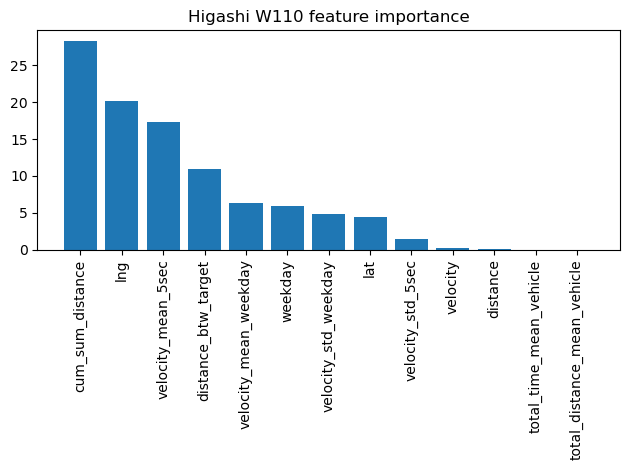

In [71]:
feature_importance('Higashi', 'W110')

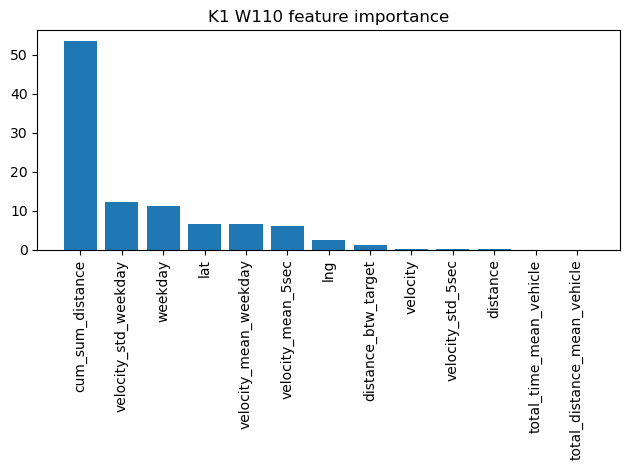

In [72]:
feature_importance('K1', 'W110')

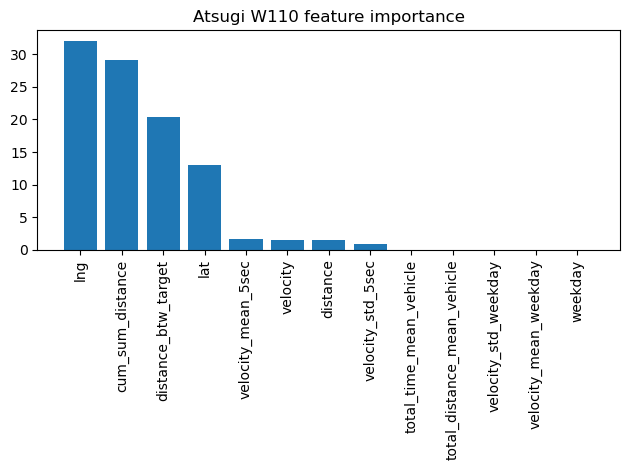

In [73]:
feature_importance('Atsugi', 'W110')

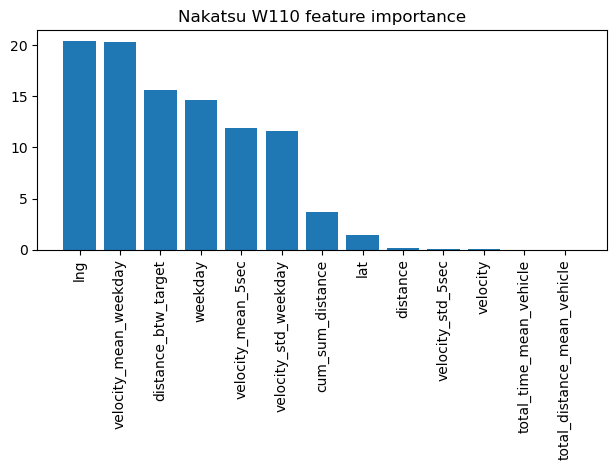

In [75]:
feature_importance('Nakatsu', 'W110')

## MAE

In [119]:
model_result = pd.read_csv('./data/model_result.csv', index_col=0)
model_result

,model,rmse,mae,r2
0,Higashi_W103_model,4.713200,2.655391,0.999953
1,Higashi_W106_model,8.700080,4.559339,0.997518
2,Higashi_W108_model,35.991370,23.903036,0.976825
3,Higashi_W109_model,21.949515,16.574514,0.935046
4,Higashi_W110_model,6.742756,3.419898,0.996056
...,...,...,...,...
155,Nakatsu_W97-2_model,108.809204,30.941585,0.962120
156,Nakatsu_W98-1_model,0.460119,0.335955,0.998997
157,Nakatsu_W98-2_model,4.161420,2.134124,0.990994
158,Nakatsu_座間エンジン（1・2・4時区）-1_model,0.314931,0.243164,0.916189


In [118]:
print(f'Total Mean of MAE : {round(model_result["mae"].mean(), 5)} min')
print(f'Best MAE : {round(model_result["mae"].min(), 5)} min')
print(f'Best MAE Model : {model_result.loc[model_result[["mae"]].idxmin()["mae"], "model"]}')
print(f'Worst MAE : {round(model_result["mae"].max(), 5)} min')
print(f'Worst MAE Model : {model_result.loc[model_result[["mae"]].idxmax()["mae"], "model"]}')

Total Mean of MAE : 23.1458 min
Best MAE : 0.24316 min
Best MAE Model : Nakatsu_座間エンジン（1・2・4時区）-1_model
Worst MAE : 371.52944 min
Worst MAE Model : Atsugi_W46_model


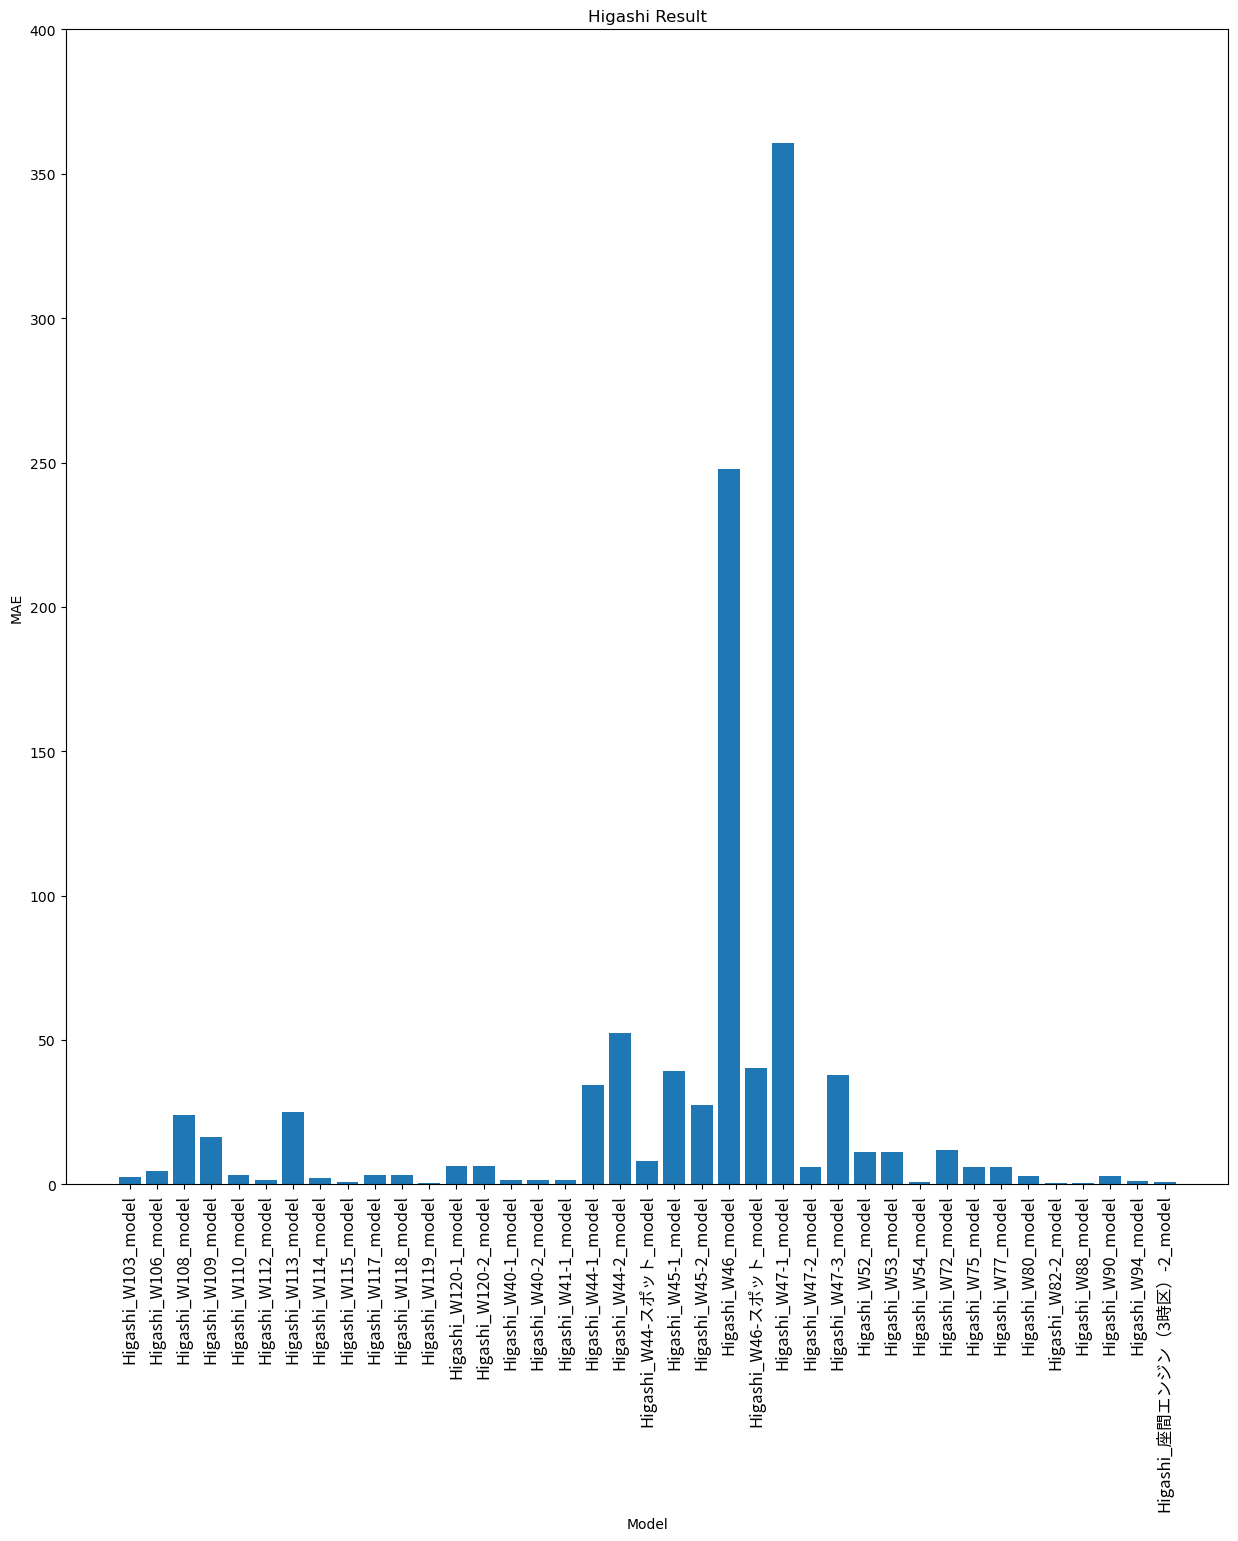

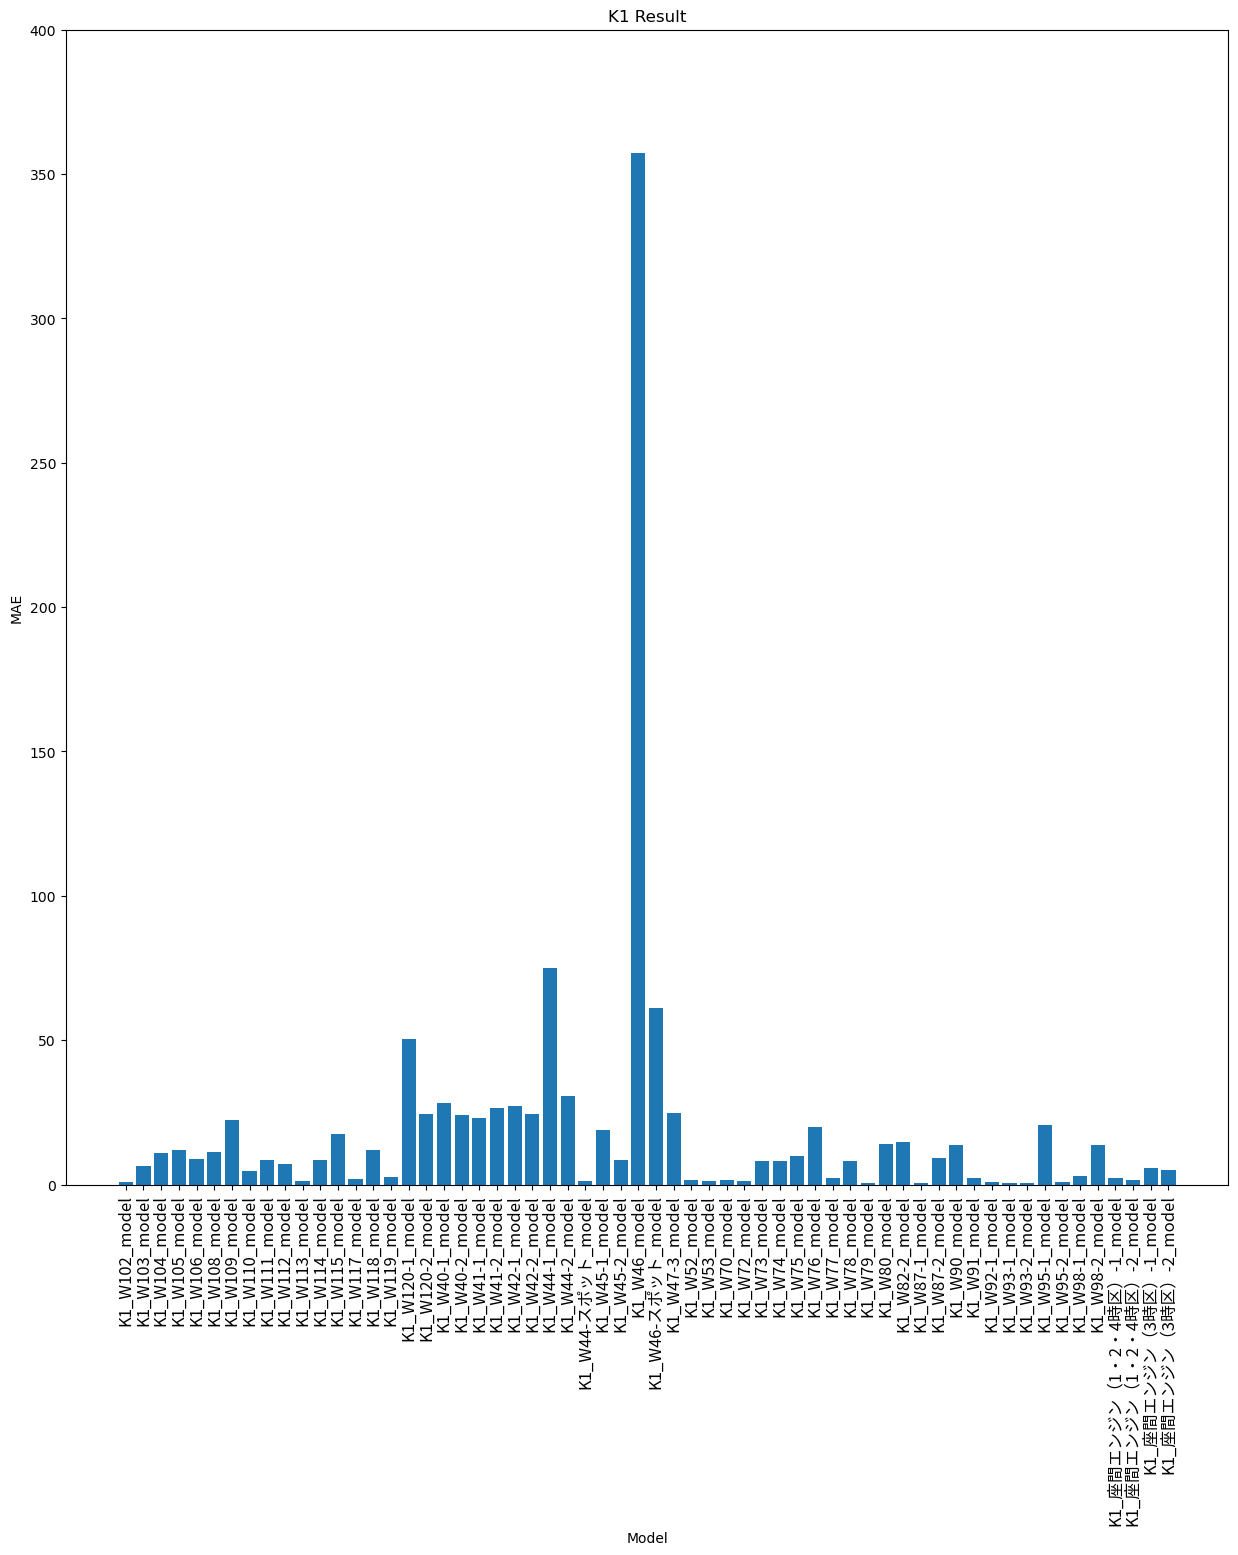

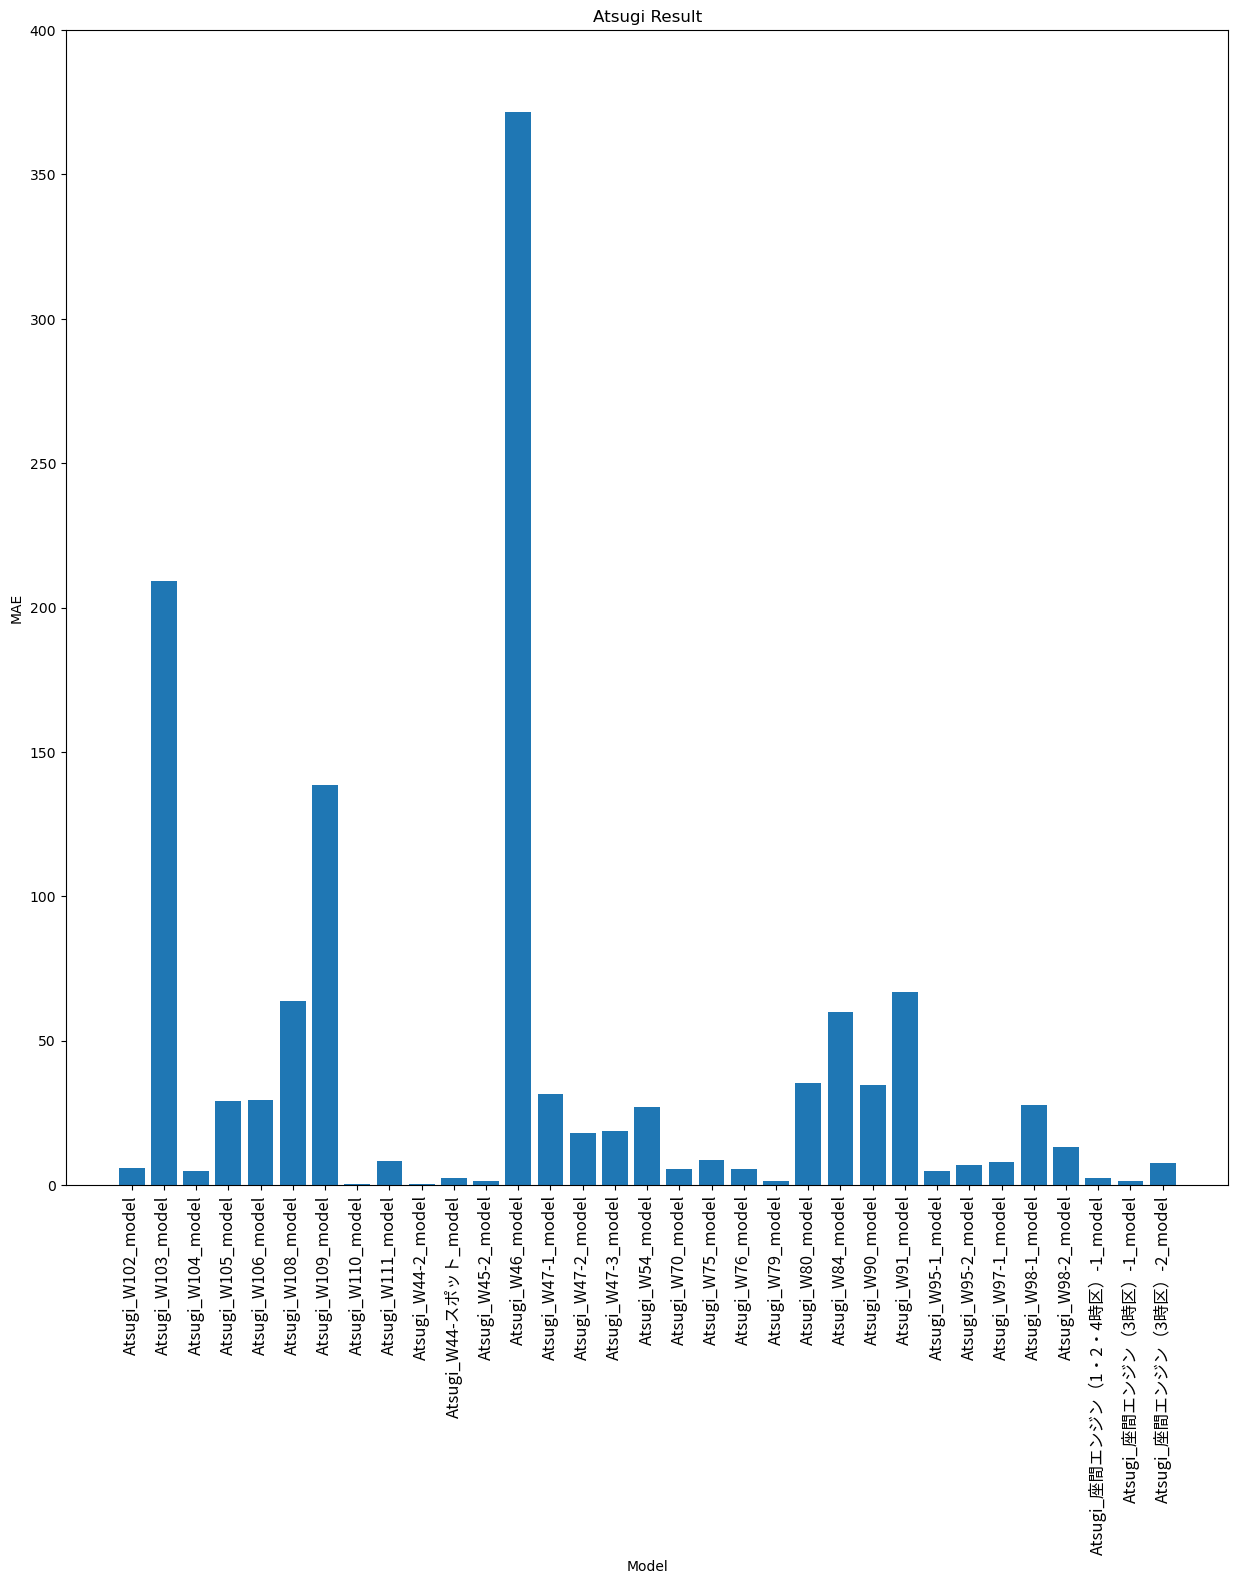

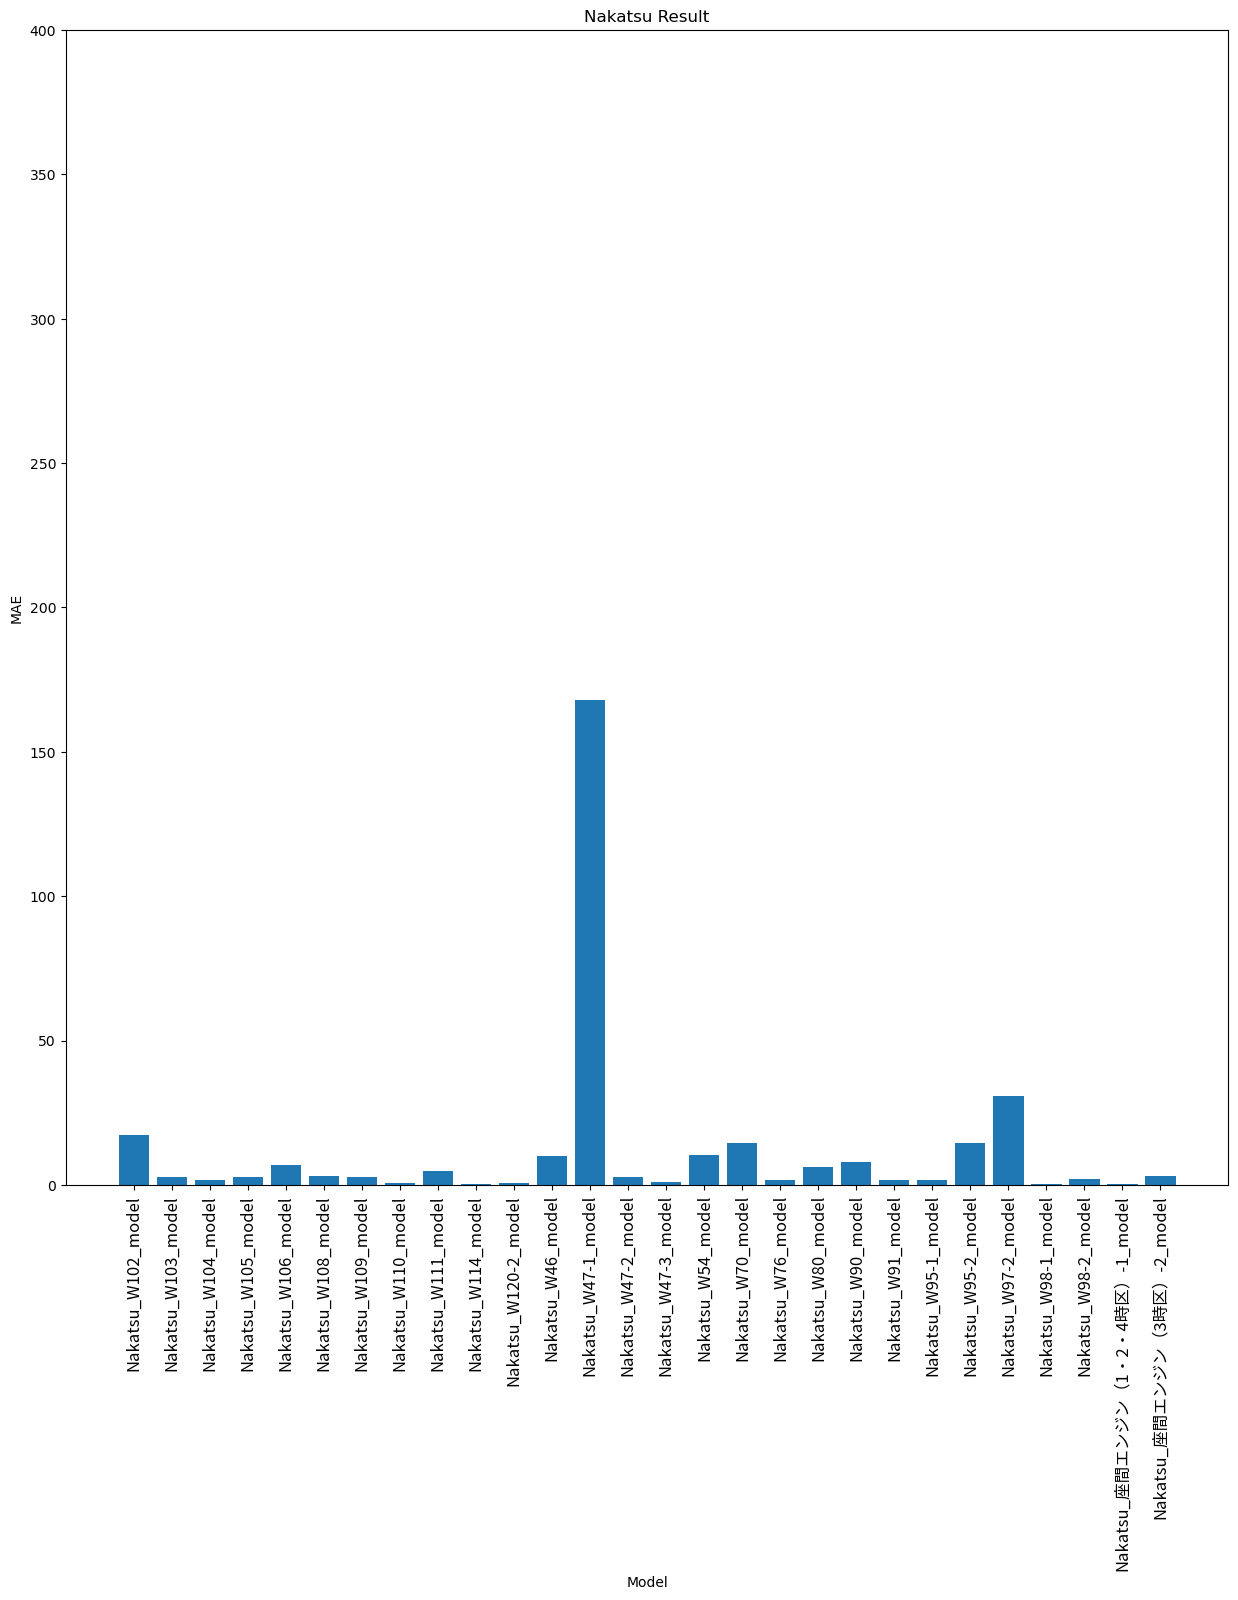

In [133]:
# MAE plot of each model
import matplotlib.font_manager as fm
fprop = fm.FontProperties(fname='./data/NotoSansJP-Regular.otf')


for i in ['Higashi', 'K1', 'Atsugi', 'Nakatsu']:
    result = model_result[model_result['model'].str.contains(i)]
    plt.figure(figsize=(15,15))
    plt.bar(result['model'], result['mae'])
    plt.xticks(fontproperties=fprop, fontsize=12, rotation=90)
    plt.xlabel('Model')
    plt.ylabel('MAE')
    plt.ylim([0, 400])
    plt.title(f'{i} Result')
    plt.show()

# Execution

In [135]:
class Truck:
    def __init__(self, df, dest, velocity_5sec_info, velocity_weekday_info):
        self.df= df
        self.prev_time = 0
        self.prev_timestamp = 0
        self.cum_distance =0
        self.dest = dest
        self.velocity_5sec_info = velocity_5sec_info
        self.velocity_weekday_info = velocity_weekday_info

    # def set_parameter(self,):
    def set_initial_timestamp(self, timestamp):
        if(self.prev_timestamp==0):
            self.prev_timestamp = datetime.datetime.strptime(timestamp[:-6],'%Y-%m-%dt%H:%M:%S')
    
    def get_truck_cum_distance(self):
        return self.cum_distance

# Loads model that predicts ETA of the destination and vehicleCode you want to predict
def get_model(destination, vehicleCode):
    try:
        model_path = f'models/{destination}_{vehicleCode}_model.model'
        model = pickle.load(open(model_path, 'rb'))
        return model
    except:
        print('❗️vehicleCode does not pass the destination❗️')

# Get trip information features based on vehicleCode
def get_initial_df(mean_route_info, vehicleCode):
    df = pd.DataFrame(columns=['vehicleCode', 'lat', 'lng', 'timestamp', 'distance', 'cum_sum_distance','distance_btw_target',\
                               'del_time', 'velocity', 'weekday', 'velocity_mean_5sec', 'velocity_std_5sec', \
                               'velocity_mean_day', 'velocity_std_day', 'cum_sum', 'total_mean_distance', \
                               'total_mean_time'])
    df.loc[0,'vehicleCode'] = vehicleCode
    df.loc[0, 'total_mean_distance']= mean_route_info[mean_route_info['vehicleCode'] == vehicleCode]['total_distance_mean_vehicle'].iloc[0]
    df.loc[0, 'total_mean_time']= mean_route_info[mean_route_info['vehicleCode'] == vehicleCode]['total_time_mean_vehicle'].iloc[0]
    return df

# Update features based on the real time data
def update(truck):
    truck.df = time_processing(truck.df)
    truck = update_del_time(truck)
    truck.df = update_velocity(truck.df)
    truck.df = update_weekday(truck.df)
    truck = update_cumsum_distance(truck)
    truck = update_constant_value(truck)
    truck.df = update_distance_btw_destination(truck.df,truck.dest)
    return truck.df

# Functions below are used to execute the 'update' function

# Convert data type of the given timestamp, lat, lng values
def time_processing(df):
    df['timestamp'] = df['timestamp'].apply(lambda x: datetime.datetime.strptime(x[:-6], '%Y-%m-%dt%H:%M:%S'))
    df['lat'] = df['lat'].astype(float)
    df['lng'] = df['lng'].astype(float)
    return df

# Calculate the time interval between the given timestamp and previous timestamp
def update_del_time(truck):
    truck.df.loc[0,'del_time'] = (truck.df.loc[0,'timestamp'] - truck.prev_timestamp).seconds
    truck.prev_timestamp = truck.df.loc[0,'timestamp']
    return truck

# Calclate current velocity using the given distance and del_time
def update_velocity(df):
    if(df.loc[0,'del_time']==0):
        df.loc[0,'velocity']=0
        return df
    df.loc[0,'velocity'] = df.loc[0,'distance']/df.loc[0,'del_time']
    return df

# Extract weekday value from the given timestamp
def update_weekday(df):
    df['weekday'] = df['timestamp'].dt.weekday
    return df

# Calculate accumulated distance by adding the given distance
def update_cumsum_distance(truck):
    truck.cum_distance += truck.df['distance']
    truck.df['cum_sum'] = truck.cum_distance
    return truck

# Get trip information features based on weekday and timestamp
def update_constant_value(truck):
    truck.df.loc[0,'velocity_mean_day'] = truck.velocity_weekday_info[truck.velocity_weekday_info['weekday']==truck.df.loc[0,'weekday']]['velocity_mean_weekday'].values[0]
    truck.df.loc[0,'velocity_std_day'] = truck.velocity_weekday_info[truck.velocity_weekday_info['weekday']==truck.df.loc[0,'weekday']]['velocity_std_weekday'].values[0]

    temp = str(truck.df.loc[0,'timestamp'].round('5s').time())
    truck.df.loc[0, 'velocity_mean_5sec'] = \
    truck.velocity_5sec_info[truck.velocity_5sec_info['five_sec'] == temp]['velocity_mean_5sec'].values[0]

    truck.df.loc[0, 'velocity_std_5sec'] = \
    truck.velocity_5sec_info[truck.velocity_5sec_info['five_sec'] == temp]['velocity_std_5sec'].values[0]
    return truck

# Calculate haversine distance between the given location and destination
def update_distance_btw_destination(df,dest):
    target_place = {}
    target_place['Higashi'] = (35.50116466410529, 139.7705922117356) #"Higashi-Ogishima"
    target_place['K1'] = (35.55769134902504, 139.66477025889324) #"K1"
    target_place['Atsugi'] = (35.47115639628905, 139.36695126985464) #"Atsugi"
    target_place['Nakatsu'] = (35.520388068094086, 139.3521451687072) #"Nakatsu"    
    df.loc[0,'distance_btw_target'] = df[['lat','lng']].apply(lambda x : haversine((x),target_place[dest]),axis=1).iloc[0]
    return df

# Model prediction
def predict_model(df, model):
    using_predict_col = ['lat','lng','distance','cum_sum_distance','velocity','distance_btw_target','weekday','velocity_mean_5sec','velocity_std_5sec','velocity_mean_day','velocity_std_day','total_mean_distance','total_mean_time']
    res = model.predict(df.loc[0, using_predict_col].values)
    return res

In [148]:
# 1. Enter final destination and vehicleCode you want to predict
destination = input('Enter Final Destination (Example : Higashi/K1/Atsugi/Nakatsu) ')
vehicleCode = input('Enter vehicleCode ')

# 2. Load Model
model = get_model(destination,vehicleCode)

# 3. Load trip information based on previous data
mean_route_info = pd.read_csv("./constant/constant_total_mean.csv")
velocity_5sec_info = pd.read_csv("./constant/constant_velocity_5sec.csv")
velocity_week_info = pd.read_csv("./constant/constant_velocity_week.csv")

# 4. Get trip information features based on vehicleCode
df = get_initial_df(mean_route_info, vehicleCode)

# 5. Generate Truck instance 
truck_instance = Truck(df,destination, velocity_5sec_info, velocity_week_info)


print("setting is done! ETA process started!")
print("-------------------------------------")

# Once the data is given, features are updated automatically and the model returns the predicted left time to the destination in real time
while(True):
    
    # 6. Enter data (latitude, longitude, distance, timestamp) collected from the gpsTracker
    input_data = input()
    
    # 6-1. Enter 'q' to stop the process
    if(input_data =='q'):
        break

    argv = input_data.split()

    truck_instance.set_initial_timestamp(argv[3])

    # 7. Update the values based on the given data
    df.loc[0,'lat'] = argv[0]
    df.loc[0,'lng'] = argv[1]
    df.loc[0,'distance'] = float(argv[2])
    df.loc[0,'timestamp'] = argv[3]

    # 8. Update features for prediction
    df = update(truck_instance)
    
    # 9. Real time prediction
    res = predict_model(df, model)
    print("left time : {} minutes".format(res))

Enter Final Destination (Example : Higashi/K1/Atsugi/Nakatsu) Higashi
Enter vehicleCode W110
setting is done! ETA process started!
-------------------------------------
35.518716 139.352116 41.077926 2022-05-23T05:55:59+09:00
left time : 384.4533900977771 minutes
35.518716 139.352116 0.000000 2022-05-23T05:56:02+09:00
left time : 385.14052492730843 minutes
35.518710 139.351960 14.166152 2022-05-23T06:03:17+09:00
left time : 376.8140454947062 minutes
q


**Input example**

Enter Final Destination : Higashi <br>
Enter vehicleCode : W110

----------------------------

35.518716 139.352116 41.077926 2022-05-23T05:55:59+09:00 <br>
35.518716 139.352116 0.000000 2022-05-23T05:56:02+09:00 <br>
35.518710 139.351960 14.166152 2022-05-23T06:03:17+09:00 <br>
q

In [149]:
# Compare the predicted result with the actual left time below
Higashi = target_df.loc[Higashi_data_index]
Higashi = feature_engineering(Higashi, 1)
Higashi[Higashi['vehicleCode']=='W110'][['vehicleCode','lat','lng','timestamp','distance','left_time']][3:6]

,vehicleCode,lat,lng,timestamp,distance,left_time
2388668,W110,35.518716,139.352116,2022-05-23 05:55:59,41.077926,378.0
2388669,W110,35.518716,139.352116,2022-05-23 05:56:02,0.000000,378.0
2388670,W110,35.518710,139.351960,2022-05-23 06:03:17,14.166152,371.0
